# generic stochastic quantum channel

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import scipy

# %matplotlib notebook 
%matplotlib inline 

In [2]:
import qutip as qutip

# https://qutip.readthedocs.io/en/latest/guide/guide.html
# https://qutip.org/qutip-tutorials/

fileroot = 'walk_05_'

In [47]:
# check to see if an np.array square matrix m is unitary 
def is_unitary(m):
    bb = np.allclose(np.eye(len(m)), m.dot(m.T.conj()), rtol=1e-05, atol=1e-08) # for square numpy array m
    return bb  # returns boolean
    
# given a Hermitian operator qutip.Qobj Hop on a 2 state system
# create an tensor product n_qubit unitary that is identity except j, j+1 qubits
# were we put the operator e^(i epsilon Hop)
# does not use any globals
def mk_interaction_small(n_qubits,Hop,epsilon,j):
    if (j <0):
        print('err j<0')
        return 0
    if (j > n_qubits-2):
        print('err j<n_qubits-2')
        return 0
    if (Hop.check_herm() != True):
        print('mk_interaction_small: Warning: Hop is not Hermitian')

    U_small_np = scipy.linalg.expm(1j*epsilon*Hop.full())  # make a small near identity transformation 
    # using scipy's expm with the hope that it will more likely to be actually unitary, the result is a numpy array 
    U_small =  qutip.Qobj(U_small_np,dims = [[2, 2], [2, 2]])
    if (U_small.isunitary != True):
        print('mk_interaction_small: U_small is not unitary')
        
    # now we make embed the interaction in the full tensor product space 
    id2 = qutip.qeye(2)  # identity 
    op_list = []  # create a list of operators 
    for k in range(0,j):
        op_list = np.append(op_list,id2)
    op_list = np.append(op_list,U_small)
    for k in range(j+2,n_qubits):
         op_list = np.append(op_list,id2)
    U_int = qutip.tensor(op_list)  # tensor product 
    if (U_int.isunitary != True):
        print('mk_interaction_small: U_int is not unitary')
    return U_int

# given a 2 qubit interaction Hop
# return an operator that is in the full system of n qubits 
# the operator is applied to the j, j+1 qubits and remainder are identities
def mk_Hop_full(n_qubits,Hop,j):
    id2 = qutip.qeye(2)  # identity 
    op_list = []  # create a list of operators 
    for k in range(0,j):
        op_list = np.append(op_list,id2)  # identities
    op_list = np.append(op_list, Hop)  # here is the operator 
    for k in range(j+2,n_qubits):
         op_list = np.append(op_list,id2)  #identies
    H_int_j = qutip.tensor(op_list)  # tensor product 
    return H_int_j

#H = mk_Hop_full(3,Qswap,1)  
#print(H.full())

# sum a series of 2 bit interactions to make a single hamiltonian operator, 
# which then can be exponentiated
# calls previous routine mk_Hop_full(n_qubits,Hop,j)
def mk_Hint_sum(n_qubits,Hop):
    H_int_j = mk_Hop_full(n_qubits,Hop,0)
    A = H_int_j
    #print(H_int_j) 
    for j in range(1,n_qubits-1):
        H_int_j = mk_Hop_full(n_qubits,Hop,j)
        A += H_int_j
        #print(H_int_j) 
    return A


# given a 1 qubit interaction Hop1
# return an operator that is in the full system of n qubits 
# the operator is applied to the j-th qubit and remainder are identities
def mk_one_op_full(n_qubits,Hop1,j):
    id2 = qutip.qeye(2)  # identity 
    op_list = []  # create a list of operators 
    for k in range(0,j):
        op_list = np.append(op_list,id2)  # identities
    op_list = np.append(op_list, Hop1)  # here is the operator 
    for k in range(j+1,n_qubits):
         op_list = np.append(op_list,id2)  #identies
    H_int_j = qutip.tensor(op_list)  # tensor product 
    return H_int_j

#Hop1 = qutip.sigmaz()
#H  = mk_one_op_full(3,Hop1,0)
#print(H)

# make a Hamiltonian that is a sum of -sigma_z on each qubit 
def mk_magnet_H(n_qubits):
    Zone = qutip.sigmaz()
    H_int_j = mk_one_op_full(n_qubits,Zone,0)
    A = H_int_j
    #print(H_int_j)
    for j in range(1,n_qubits):
        H_int_j = mk_one_op_full(n_qubits,Zone,j)
        A += H_int_j
        #print(H_int_j) 
    return -1*A  # notice minus here!!!!!!!
    
#H  = mk_magnet_H(3)
#print(H)
        
# do a reset on density operator rho on last qubit 
# with trace instead of Kraus ops
def reset_channel(rho,n_qubits):
    ilist = np.arange(0,n_qubits-1)  # keep all but last one 
    rho_short = rho.ptrace(ilist)    # partial trace out the last qubit 
    ket0 = qutip.basis(2, 0) # |0>
    K0 = ket0*ket0.dag() #|0><0|
    op_list = [ rho_short, K0] 
    rho_new =qutip.tensor(op_list) # make new_rho = (tr_n-1 rho) \otimes |0><0|
    return rho_new

#do a depolarization channel on first qubit 
def depol_channel(rho,n_qubits):
    ilist = np.arange(1,n_qubits) # keep all but first one
    rho_short = rho.ptrace(ilist)    # trace out first qubit 
    id2 = qutip.qeye(2)  # identity op
    op_list = [ id2/2,rho_short ] 
    rho_new =qutip.tensor(op_list)  # make new_rho = I/2 \otimes (tr_0 rho) 
    return rho_new

In [250]:
# make a figure showing -<sigma_z> for each qubit (tracing out the others)
# imax is a maximum limit 
# mtype= 'x','y','z' determines whether -<Y> -<Z> or -<X> is plotted 
# sim is a walkit class of channel simulation 
def sigz_fig(sim,imax=0,mtype='z',ablabel=''):
    colorlist = ['red','orange','gold','green','blue','violet','gray']
    nc = len(colorlist)
    fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=200)
    plt.subplots_adjust(bottom=0.15,left=0.2,top=0.98,right=0.98)
    #i0=500
    mz0 = np.squeeze(sim.mz_store[0:,0])  # used in x axis for iterations
    nit = np.arange(len(mz0)) # used in x axis for iterations
    jmax = len(mz0)
    if (imax >0) and (imax < jmax):
        jmax = imax
   
    for j in range(sim.n_qubits):
        if   (mtype =='x'):
            mm = np.squeeze(sim.mx_store[0:,j])
        elif (mtype =='y'):
            mm = np.squeeze(sim.my_store[0:,j])
        else: # (mtype =='z'):    
            mm = -np.squeeze(sim.mz_store[0:,j]) # notice minus sign is here!!!!!
        #print(np.mean(mz[i0:]),np.std(mz[i0:]))
        ilabel = '{:d}'.format(j)
        ax.plot(nit[0:jmax],mm[0:jmax],'.',color=colorlist[j%nc],ms=1,label=ilabel)  
        
    ax.set_xlabel('iteration',fontsize=12)
    yl = r'$p_' + mtype + '$ each qubit'
    if (mtype =='z'):
        yl = '-' + yl
    #yl = 'polarization' + yl
    ax.set_ylabel(yl,labelpad=-1,fontsize=12)
    ax.text(-0.2,0.95, ablabel,transform=ax.transAxes,fontsize=14)
    fig_label = sim.inter_label + r',$\epsilon$={:.2f},'.format(sim.epsilon)+ r'$n$={:d}'.format(sim.n_qubits)
    if (sim.zeta >0):
        fig_label += '\n' + r'$\zeta$={:.1f}'.format(sim.zeta)
    
    ax.text(0.5,0.97, fig_label,transform=ax.transAxes,fontsize=14,ha='center',va='top')
    ax.legend(markerscale=1.9,borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,borderaxespad=0.1,loc='upper right')
    
    #ax.text(0.5,0.92, fig_label2,transform=ax.transAxes,fontsize=14,ha='center',va='top')
    
    ofile = fileroot+sim.sim_label+'_s' + mtype + '.png'
    print(ofile)
    plt.savefig(ofile)
    plt.show()

#sigz_fig(sim1,1000,'z',ablabel='a)')

# plot histograms of polarization measurements
# only using from i0 onwards 
def plt_hists(sim,i0,mtype='z',ablabel=''):
    colorlist = ['red','orange','gold','green','blue','violet','gray','brown']
    nc = len(colorlist)
    ls_list = ['-', '--', '-.', ':']
    nls = len(ls_list)
    
    fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=200)
    plt.subplots_adjust(bottom=0.17,left=0.2,top=0.98,right=0.98)

    lws = np.linspace(1,2,sim.n_qubits)

    bins=np.linspace(-0.4,0.4,40)
    
    for j in range(sim.n_qubits-1):
        if   (mtype =='x'):
            mz = np.squeeze(sim.mx_store[i0:,j])
            
        elif (mtype =='y'):
            mz = np.squeeze(sim.my_store[i0:,j])
        else: # (mtype =='z'):    
            mz = np.squeeze(sim.mz_store[i0:,j])
            bins=np.linspace(-1,0.5,40)
        ax.hist(-mz,bins=bins,density=True,edgecolor=colorlist[j%nc],alpha=1,histtype='step', linewidth=lws[j]) 
        # ,linestyle = ls_list[j%nls])
        ax.hist(-mz,bins=bins,density=True,facecolor=colorlist[j%nc],alpha=0.3,histtype='stepfilled', linewidth=1)

    ax.set_xlim([min(bins),max(bins)])
    yl = 'polarization ' + r'-$p_' + mtype + '$'
    ax.set_xlabel(yl,fontsize=12)
    ax.set_ylabel('distribution',fontsize=12)
    ax.text(-0.16,0.95, ablabel,transform=ax.transAxes,fontsize=14)
    fig_label = sim.inter_label +'\n'+ r'$\epsilon$={:.2f}'.format(sim.epsilon)+ '\n'+r'$n$={:d}'.format(sim.n_qubits)
    if (sim.zeta >0):
        fig_label += '\n' + r'$\zeta$={:.1f}'.format(sim.zeta)
    ax.text(0.9,0.97, fig_label,transform=ax.transAxes,fontsize=14,ha='right',va='top')
    
    ofile = fileroot+sim.sim_label + 'h' + mtype +'.png'
    print(ofile)
    plt.savefig(ofile)
    plt.show()

#plt_hists(sim1,1000,mtype='z')
        

In [234]:
# make a 2 qubit swap operator 
Qswap = qutip.Qobj([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]],
            dims = [[2, 2], [2, 2]],
            isherm=True,isunitary=True)
#Qswap.full() gives array

# this is the same thing as sigma_+^0 sigma_-^2 + sigma_-^0 sigma_+^2
Qswap_short = qutip.Qobj([[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]],
            dims = [[2, 2], [2, 2]],
            isherm=True)  # notice no terms on diagonal, is not unitary

# controlled not with first bit the control bit 
QCnotC0 =  qutip.Qobj([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]],
            dims = [[2, 2], [2, 2]],
            isherm=True,isunitary=True)

# controlled not with second bit the control bit 
QCnotC1 =  qutip.Qobj([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]],
             dims = [[2, 2], [2, 2]],
            isherm=True,isunitary=True)

# the Heisenberg spin interaction (sum of pairs of Paulis)
# this is the same thing as sigma_+^1 sigma_-^2 + sigma_-^1 sigma_+^2 + sigma_z^1 sigma_z^2
# which is sum_i sigma_i^1 sigma_i^2
QHeis = qutip.Qobj([[1, 0, 0, 0], [0, -1, 2, 0], [0, 2, -1, 0], [0, 0, 0, 1]],
            dims = [[2, 2], [2, 2]], isherm=True)


In [232]:
# class definition for carrying out a stochastic random walk channel on n-qubits 
# random op on first qubit
# reset on last qubit
# in between exponentially small versions of an 2qubit operator that we pass  
# calls above routines: reset_channel(), mk_interaction_small(), is_unitary(), depol_channel()
#   mk_Hint_sum(), mk_Hop_full(), mk_magnet_H(n_qubits)
class walkit():
    # init: arguments:
    #  n_qubits:  number of qubits
    #  epsilon:  strength of 2qubit local interaction  - can be an array  length n_qubits - 1
    #  H_2bits:  Hermitian 2qubit interaction operator qutip.Qobj
    #  sim_label:  a string label for simulation
    #  inter_type :   a string specifying type of interaction 
    #  inter_label:   a label for the interaction operator 
    #  alpha : if 1 then we only have random channel, if less than 1 you can dilute the random channel with identity or depolarization
    #  beta :  add in a fraction of depolarization channel 
    #  zeta: add in some magnetic field energy  
    def __init__(self,n_qubits,epsilon,H_2bits,sim_label,inter_type='seq',inter_label='Swap',alpha=1.0,beta=0.0,zeta=0.0):
        self.n_qubits = n_qubits  # number of qubits in chain 
        self.N = 2**n_qubits
        if (isinstance(epsilon, float)):
            self.epsilon_arr = epsilon + np.zeros(n_qubits-1)  # perturbation parameter or parameters 
            self.epsilon = epsilon
        else:
            self.epsilon_arr = epsilon
            if (len(epsilon) < n_qubits - 1):
                print("epsilon array too short")
        self.H_2bits = H_2bits  # Hermitian op qutip.Qobj
        self.sim_label = sim_label  # a string label for labelling 
        self.inter_type = inter_type  # interaction type 
        self.inter_label = inter_label  # interaction name label 
        self.zeta = zeta  # strength of magnetic energy 
        self.alpha = alpha  # strength of random channel, if less than 1 dilute it 
        self.beta = beta  # if not equal to zero then dilute random change by some fraction of depolarization channel 
        
        self.init_rho()  # initialize to the ground state, makes self.rho
        self.mk_int_prod()  # make an interaction unitary  self.U_int_prod  using self.epsilon_arr and self.H_2bits
        
        if (beta <0):
            print('error: beta should be positive')
        if (alpha <0):
            print('error: alpha should be positive')
        if (beta >1):
            print('error: beta should be less than 1')
        if (alpha >1):
            print('error: alpha should be less than 1')
        if (alpha+beta>1):
            print('error: alpha+beta should be less than 1')
        

    # create density operator from ground state in all qubits 
    # creates self.rho and self.rho_init
    def init_rho(self):
        ket0 = qutip.basis(2, 0)
        op_list = []
        for j in range(self.n_qubits):
            op_list = np.append(op_list,ket0)
        psi  = qutip.tensor(op_list) # this is a ket, not an operator 
        self.rho = qutip.ket2dm(psi)  # make density operator from statevector psi
        self.rho_init = self.rho  # keep a copy
        
    # make an interaction unitary of a product of near identity operators based on a 2 qubit operator self.H_2bits
    # creates self.U_int_prod and dagger self.U_int_prod_dagger
    # this is a sequential product of 2qubit operators 
    def mk_int_prod(self):
        
        if (self.inter_type == 'seq'):  # we use a sequential product of interactions with strengths epsilon_arr
            U_int_prod  = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[0],0) # external routine 
            # this is a n_qubit operator that has e^{i epsilon H_2bits} operating on first two qubits
            # and is identity in the rest 
            for j in range(1,self.n_qubits-1):  # from 1 to n-1
                U_int = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[j],j)    # sequential local interactions
                U_int_prod = U_int*U_int_prod   # is a product of all these interactions operators 
            self.U_int_prod = U_int_prod  # returns nothing, but creates self.U_int_prod

        elif (self.inter_type == 'brick'): # even and odd bricks 
            U_int_prod_even = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[0],0) # external routine 
            U_int_prod_odd  = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[1],1) 
            for j in range(2,self.n_qubits-1,2):  # from 2 to n-1, in non-touching but proximate pairs
                U_int = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[j],j)    # sequential local interactions
                U_int_prod_even = U_int*U_int_prod_even   # is a product of all these interactions operators, pairs
            for j in range(3,self.n_qubits-1,2):  # from 3 to n-1, in non-touching but proximate pairs
                U_int = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[j],j)    # sequential local interactions
                U_int_prod_odd = U_int*U_int_prod_odd   # is a product of all these interactions operators, pairs
            U_int_prod = U_int_prod_odd*U_int_prod_even
            self.U_int_prod = U_int_prod  # returns nothing, but creates self.U_int_prod

        else:   # sum the Hamiltonian and then exponentiate
            H_int = self.epsilon*mk_Hint_sum(self.n_qubits,self.H_2bits)  # sum pairs of consecutive interactions  
            if (self.zeta != 0):
                H_mag = self.zeta*mk_magnet_H(self.n_qubits)
                H_int += H_mag  # add some magnetic field energy !!!
            U_int_prod = (1j*H_int).expm()  # exponential of Hamiltonian 
            self.U_int_prod = U_int_prod  # returns nothing, but creates self.U_int_prod

        self.U_int_prod_dagger = self.U_int_prod.dag()  # store the self-adjoint 

        # checks!
        if (self.U_int_prod.isunitary != True):
            print('warning: U_int_prod is not unitary!')
        bb = is_unitary(self.U_int_prod.full())
        if (bb != True):
            print('warning: U_int_prod is not unitary (bb)')
                  
    # interactions then reset then random, then update rho
    def do_channel(self):

        new_rho = self.U_int_prod * (self.rho * self.U_int_prod_dagger)  # interactions 
        new_rho2 = reset_channel(new_rho,self.n_qubits)  # reset channel
        U_rand = self.create_rand_op(0) # random op in first qubit, internal routine 
        U_rand_dagger = U_rand.dag()
        # U_rand must be remade every time this routine is called 
        new_rho3_a = U_rand * (new_rho2 * U_rand_dagger) # random 
        if (self.beta >0):
            new_rho3_b = depol_channel(new_rho2,self.n_qubits)  # depol 
        else :
            new_rho3_b = 0.0
        new_rho4 = self.alpha*new_rho3_a + self.beta*new_rho3_b + (1- self.alpha - self.beta)*new_rho2   
        # allow dilution of random channel by depolarization or and identity 
        # sum with last begin identity 
        self.rho = new_rho4  # update density operator 

    # iterate ntimes x nstore
    # store traced density operators nstore times 
    def iterate(self,ntimes,nstore,do_checks=False):
        rho_store = np.zeros([nstore,self.n_qubits,2,2],dtype=complex)
        mx_store = np.zeros([nstore,self.n_qubits])
        my_store = np.zeros([nstore,self.n_qubits])
        mz_store = np.zeros([nstore,self.n_qubits])
        for k in range(nstore):
            for m in range(ntimes):  # iterate ntimes 
                self.do_channel()
            for j in range(self.n_qubits):
                rho_j = self.rho.ptrace(j)  # partial trace all qubits but the jth one
                rho_store[k,j,:,:] = rho_j.full()  # try to store each partial trace 
                mx = np.real( (rho_j*qutip.sigmax()).tr())  # measure x,y,z in each qubit
                my = np.real( (rho_j*qutip.sigmay()).tr())  #
                mz = np.real( (rho_j*qutip.sigmaz()).tr())
                mx_store[k,j] = mx
                my_store[k,j] = my
                mz_store[k,j] = mz
            if (do_checks==True):
                rhot = np.trace(self.rho.full())
                if (rhot > 1.2):
                    print('warning: trace rho >1.2')  # if you have screwed up badly!
                    break
        self.rho_store = rho_store
        self.mx_store = mx_store  # store some polarization measurements
        self.my_store = my_store
        self.mz_store = mz_store
        self.ntimes = ntimes
        self.nstore = nstore

    # create a unitary operator that is a tensor product of identity on all qubits but the j-th one 
    # and is random Haar on the j-th one
    # indexing j=0 to n_qubits-1
    # does not use any globals
    # returned operater is a unitary on full n_qubit system
    def create_rand_op(self,j):
        id2 = qutip.qeye(2)  # identity on a single qubit 
        R2 = qutip.random_objects.rand_unitary(2)  # Haar random on 2 state  (single qubit)
        op_list = []  # create a list of operators  that is n_qubits long
        for k in range(0,j):
            op_list = np.append(op_list,id2)  # insert identities 
        op_list = np.append(op_list,R2)  # put in the random op
        for k in range(j+1,self.n_qubits):
            op_list = np.append(op_list,id2) # more identities 
        U_rand = qutip.tensor(op_list)   # tensor product of n_qubit number of 2 state systems 
        return U_rand

    # for iterations stored past index i1 return means and standard deviations for each qubit polarizations 
    def simstats(self,i1):
        self.muz = np.zeros(self.n_qubits)  # not bothering with mean of x,y because they are close to zero
        self.sigz = np.zeros(self.n_qubits)
        self.sigx = np.zeros(self.n_qubits)
        self.sigy = np.zeros(self.n_qubits)
        for j in range(self.n_qubits):
            mz = np.squeeze(self.mz_store[i1:,j])
            mx = np.squeeze(self.mx_store[i1:,j])
            my = np.squeeze(self.my_store[i1:,j])
            self.muz[j] = np.mean(mz)  # store mean of z polarizations 
            self.sigz[j] = np.std(mz)   # store standard deviation of z polarizations
            
            self.sigx[j] = np.std(mx)   # store standard deviation of x polarizations
            self.sigy[j] = np.std(my)   



In [198]:
i0_fid = 2000

In [199]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S1'
inter_label = 'Swap' + r'$_s$'
sim1 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='seq',inter_label=inter_label)
mtimes = 1 
nstore = 10000+i0_fid  
sim1.iterate(mtimes,nstore)  # 
sim1.simstats(2000)

walk_05_S1_sz.png


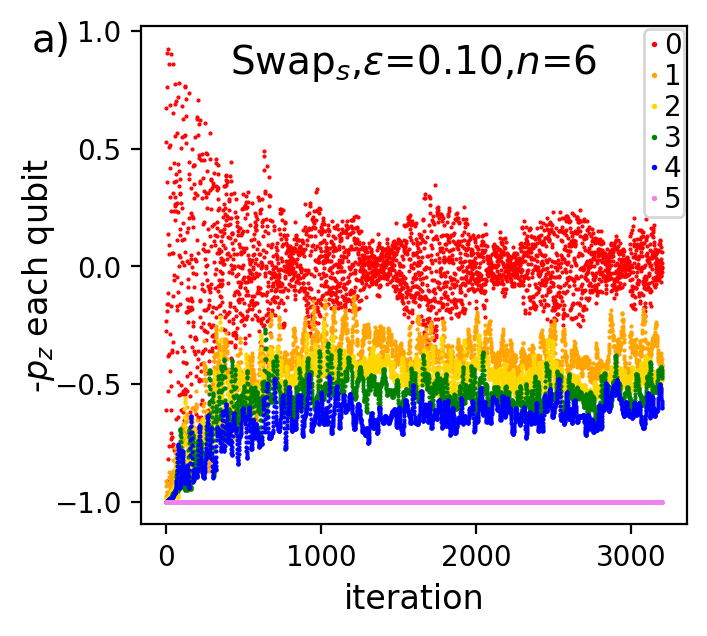

In [235]:
sigz_fig(sim1,imax=3200,mtype='z',ablabel='a)')

walk_05_S1hz.png


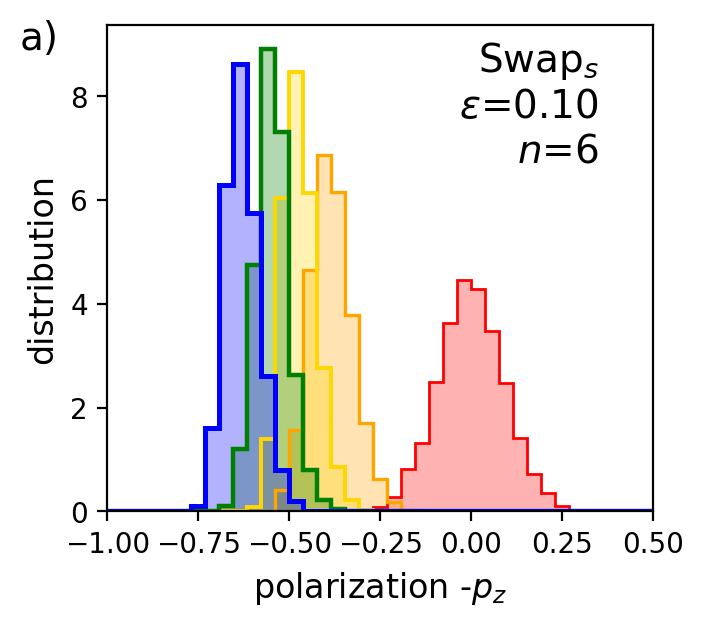

In [251]:
plt_hists(sim1,i0_fid,mtype='z',ablabel='a)')  # last qubit not plotted!

walk_05_S1hx.png


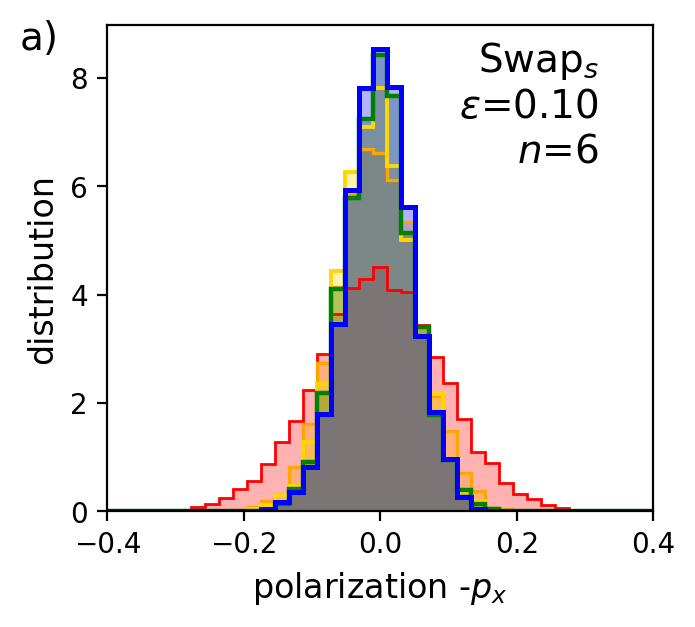

walk_05_S1hy.png


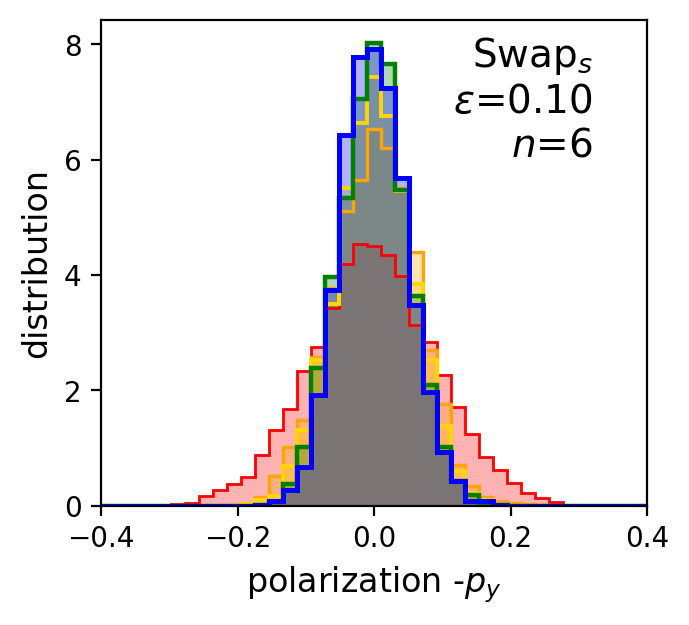

In [252]:
plt_hists(sim1,i0_fid,mtype='x',ablabel='a)')
plt_hists(sim1,i0_fid,mtype='y')

walk_05_S1_sy.png


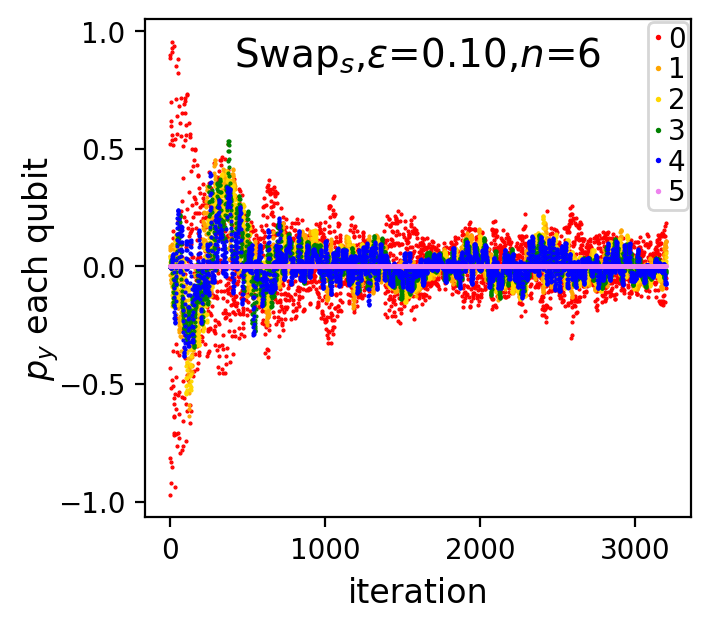

In [185]:
sigz_fig(sim1,imax=3200,mtype='y')

In [214]:
n_qubits = 6
epsilon = 0.05;  # lowering interaction strength
sim_label = 'S1b'
inter_label = 'Swap' + r'$_s$'
sim1b =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='seq',inter_label=inter_label)
mtimes = 1 
nstore = 10000 + i0_fid*2
sim1b.iterate(mtimes,nstore)  # 
sim1b.simstats(i0_fid*2)

In [204]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S1c'
inter_label = 'Swap' + r'$_e$'  # exponential interaction insted of sequential product 
sim1c =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='sum',inter_label=inter_label)
mtimes = 1 
nstore = 10000 + i0_fid
sim1c.iterate(mtimes,nstore)  # 
sim1c.simstats(i0_fid)

In [205]:
# check if we add magnetic energy parameter of zeta=1
n_qubits = 6
epsilon = 0.1;
sim_label = 'S1d'
inter_label = 'Swap' + r'$_e$'
sim1d =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='sum',inter_label=inter_label,zeta=1.0)
mtimes = 1 
nstore = 10000 + i0_fid
sim1d.iterate(mtimes,nstore)  # 
sim1d.simstats(i0_fid)

walk_05_S1b_sz.png


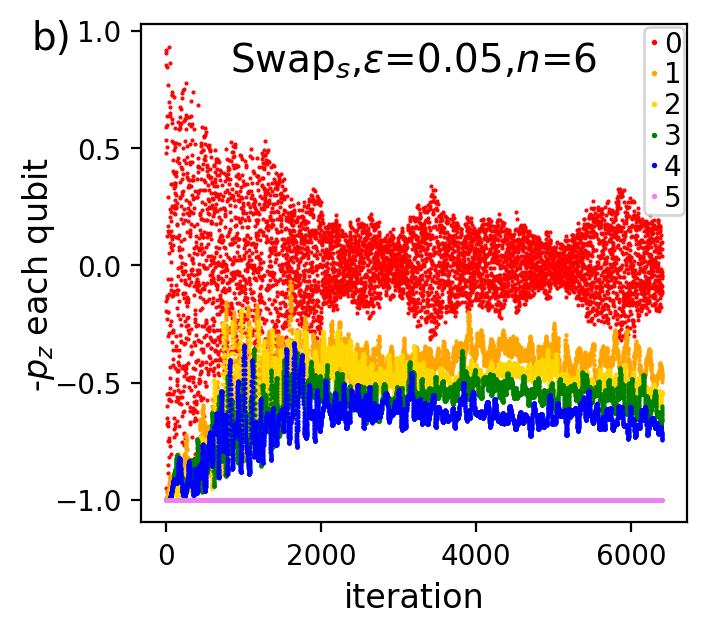

In [215]:
sigz_fig(sim1b,imax=3200*2,ablabel='b)')

walk_05_S1c_sz.png


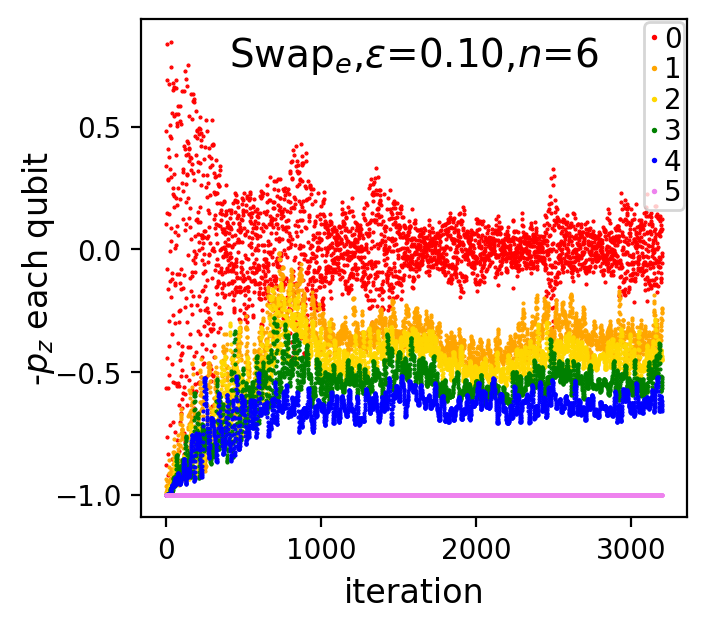

In [207]:
sigz_fig(sim1c,imax=3200,ablabel='')

walk_05_S1d_sz.png


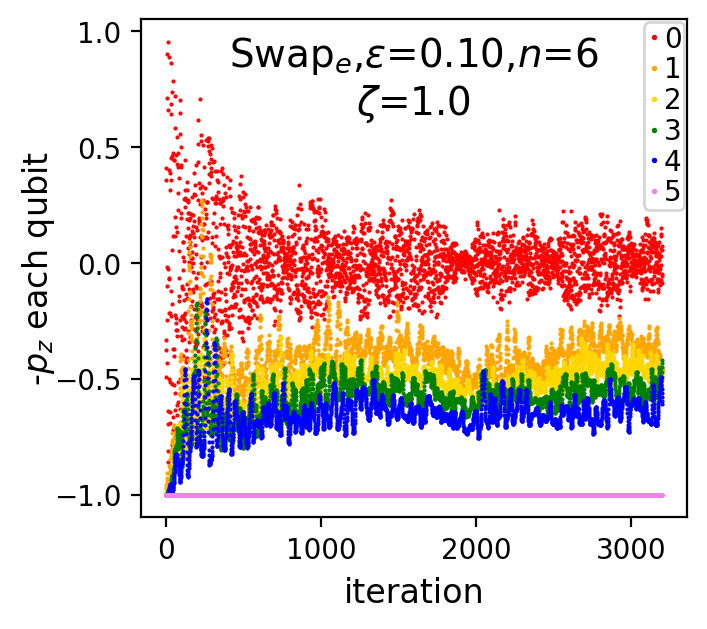

In [209]:
sigz_fig(sim1d,imax=3200,ablabel='')

walk_05_S1bhz.png


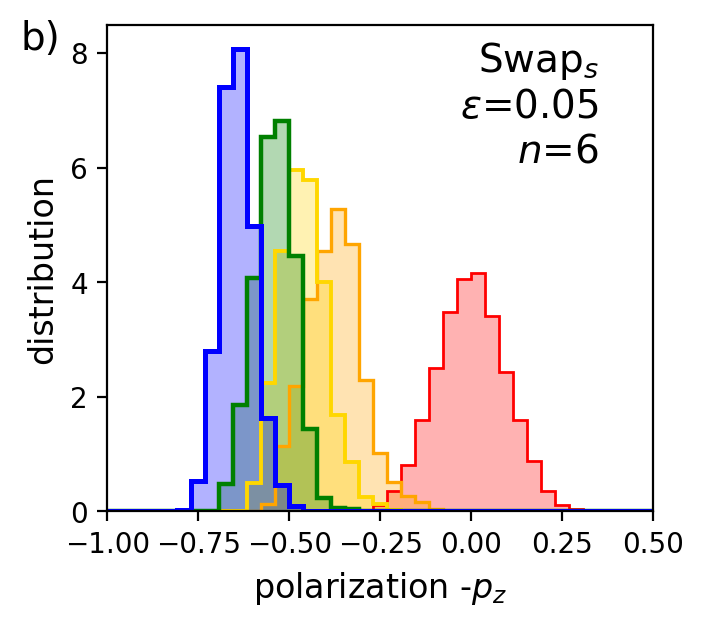

In [253]:
plt_hists(sim1b,i0_fid*2,mtype='z',ablabel='b)')

walk_05_S1chz.png


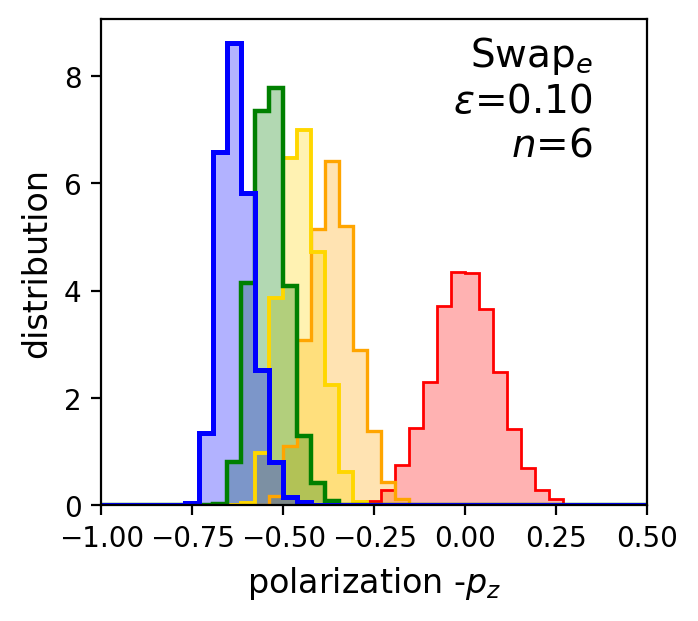

In [254]:
plt_hists(sim1c,i0_fid,mtype='z',ablabel='')  # last qubit not plotted!

walk_05_S1dhz.png


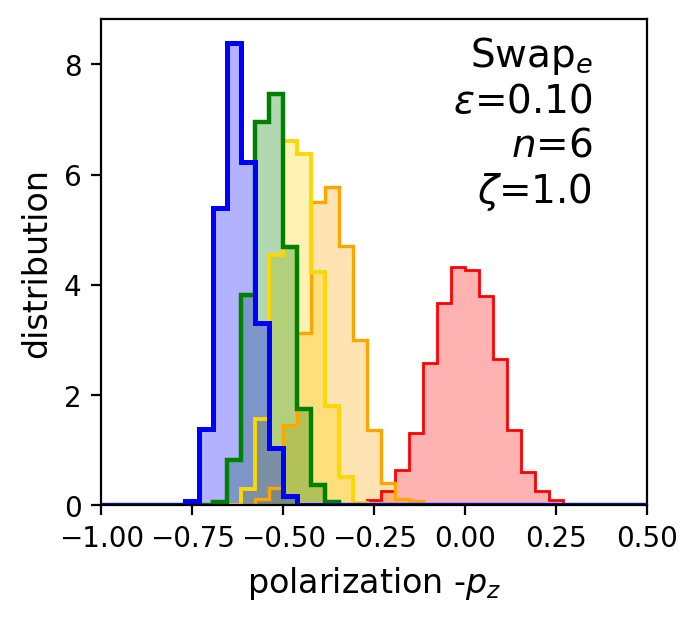

In [255]:
plt_hists(sim1d,i0_fid,mtype='z',ablabel='')  # last qubit not plotted!

walk_05_S1bhx.png


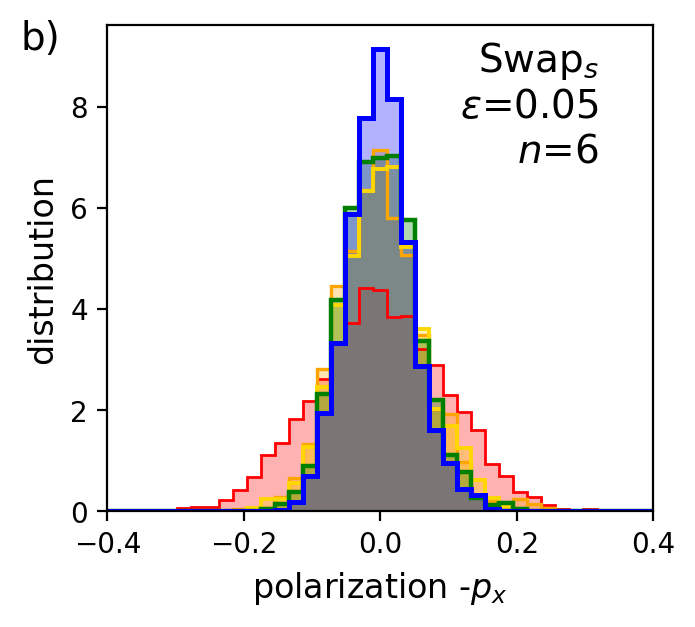

In [257]:
plt_hists(sim1b,i0_fid*2,mtype='x',ablabel='b)')

In [247]:
def mkxy(sim):  # get a vector of pz means and stds 
    x = np.arange(sim.n_qubits) 
    fac = sim.n_qubits -1
    x = x/fac
    y = sim.muz
    yerr = sim.sigz
    return x,y,yerr 

# figure to compare <p_z> values between different simulations 
def nfig(simlist,ofile,do_nlabel=True,xshifts=None,extra=''):
    fig,ax = plt.subplots(1,1, figsize=(3.5,3.0),dpi=200)
    plt.subplots_adjust(left=0.2,bottom=0.15,top=0.98,right=0.98)

    colorlist = ['red','orange','gold','lightgreen','green','cyan','blue','violet']
    markerlist = ['o','s','h','^','>']
      
    j = 0
    clabel =''
    for sim in simlist:
        x,y,yerr = mkxy(sim)
        if (do_nlabel==True):
            clabel = '{:d}'.format(sim.n_qubits)
        else:
            clabel = sim.sim_label
        if (isinstance(xshifts, np.ndarray)):  # allow x positions to shift 
            x += xshifts[j]
        ax.errorbar(x,-y,yerr = yerr, fmt = markerlist[j%len(markerlist)], \
                    capsize=3,ms=4, label=clabel,color=colorlist[j%len(colorlist)],alpha=0.7)
        j=j+1

    sim = simlist[0]
    l_label = ''
    if (do_nlabel==True):
        l_label = 'N'
        fig_label = sim.inter_label +'\n'+ r'$\epsilon$={:.2f}'.format(sim.epsilon) 
        #+ '\n'+r'$n$={:d}'.format(sim.n_qubits)
        if (sim.zeta >0):
            fig_label += '\n' + r'$\zeta$={:.1f}'.format(sim.zeta)
    else: 
        fig_label = r'$\epsilon$={:.2f}'.format(sim.epsilon) 
    ax.text(0.05,0.05, fig_label,transform=ax.transAxes,fontsize=14,ha='left',va='bottom')
        
    ax.legend(markerscale=1.1,borderpad=0.2,labelspacing=0.2,handlelength=0.5,\
              handletextpad=0.2,borderaxespad=0.2,loc='upper right',title=l_label)
    #ax.legend(markerscale=1.9,borderpad=0.1,labelspacing=0.1,handlelength=0.5,\
    # handletextpad=0.1,borderaxespad=0.1,loc='upper right')
    ax.set_ylabel(r'$p_z$ each qubit',labelpad=-3)
    ax.set_xlabel(r'position in chain $j/(n-1)$')

    if (len(extra)>3):
        ax.text(0.5,0.95, extra,transform=ax.transAxes,fontsize=14,ha='center',va='top')

    plt.savefig(ofile)
    plt.show()



In [218]:
# NS series: seq interactions, epsilon =0.1, no magnetic field energy
epsilon = 0.1;
inter_label='SWAP' + r'$_s$'
mtimes = 1 
nstore = 6000
inter_type = 'seq'
sim_label_start = 'N' + r'$_s$'
i0=1400

n_qubits = 6
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_ns6 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type )
sim_ns6.iterate(mtimes,nstore)  # 
sim_ns6.simstats(i0)

n_qubits = 9
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_ns9 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type )
sim_ns9.iterate(mtimes,nstore)  # 
sim_ns9.simstats(i0)

In [219]:
#NE series, exponent type, epsilon=0.1 no magnetization
epsilon = 0.1;
inter_label='SWAP' + r'$_e$'
mtimes = 1 
nstore = 6000
inter_type = 'sum'
sim_label_start = 'N$_e$'
i0 =1400

n_qubits = 3
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_ne3 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type,inter_label=inter_label )
sim_ne3.iterate(mtimes,nstore)  # 
sim_ne3.simstats(i0)

n_qubits = 4
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_ne4 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type )
sim_ne4.iterate(mtimes,nstore)  # 
sim_ne4.simstats(i0)

n_qubits = 5
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_ne5 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type )
sim_ne5.iterate(mtimes,nstore)  # 
sim_ne5.simstats(i0)

n_qubits = 6
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_ne6 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type )
sim_ne6.iterate(mtimes,nstore)  # 
sim_ne6.simstats(i0)

n_qubits = 7
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_ne7 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type )
sim_ne7.iterate(mtimes,nstore)  # 
sim_ne7.simstats(i0)

n_qubits = 8
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_ne8 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type )
sim_ne8.iterate(mtimes,nstore)  # 
sim_ne8.simstats(i0)

n_qubits = 9
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_ne9 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type )
sim_ne9.iterate(mtimes,nstore)  # 
sim_ne9.simstats(i0)

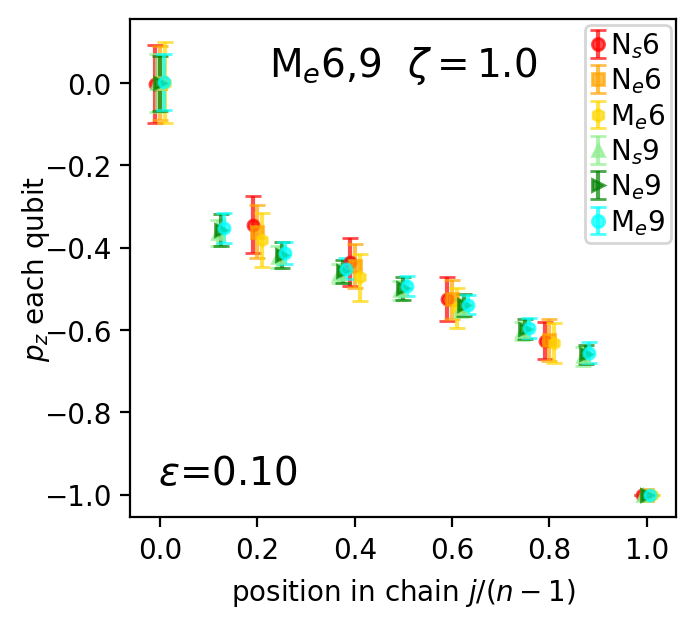

In [248]:
simlist = [sim_ns6, sim_ne6,sim_mm6, sim_ns9,sim_ne9,sim_mm9]
xshifts = np.zeros(len(simlist))
xshifts[0] = -0.01
xshifts[2] = 0.01
xshifts[3] = -0.007
xshifts[5] = 0.007
#simlist = [sim_m6,sim_mm6, sim_m9,sim_mm9]
ofile = fileroot + 'ncomp4.png'
zeta_label = r'M$_e$6,9  $\zeta={:.1f}$'.format(sim_mm6.zeta)
nfig(simlist,ofile,do_nlabel=False,xshifts=xshifts,extra=zeta_label)

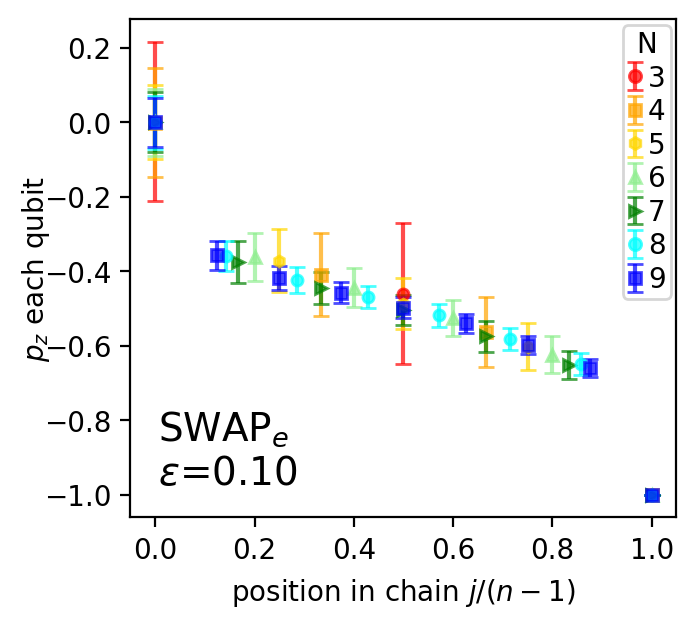

In [249]:
ofile = fileroot + 'ncomp2.png'
simlist = [sim_ne3, sim_ne4, sim_ne5, sim_ne6, sim_ne7, sim_ne8,sim_ne9]
nfig(simlist,ofile)

In [261]:
x,y,yerr = mkxy(sim_ne9) # get the mean pz values 
#print(y)
TT = np.arctanh(y[1:-1])
print(y[1],y[-2])
print(TT[0],TT[-1])
print(1/TT[0], 1/TT[-1])

0.35648924285560957 0.6591618983245062
0.37285822923935696 0.7913301419655813
2.681984522750196 1.2636950710813373


In [222]:
y

array([2.06532717e-04, 3.56489243e-01, 4.17286831e-01, 4.56998792e-01,
       4.98175262e-01, 5.39237358e-01, 5.97768525e-01, 6.59161898e-01,
       1.00000000e+00])

In [157]:

## mm series, magnetic field energy , exponent type interaction, epsilon = 0.1
epsilon = 0.1;
inter_label='SWAP'
mtimes = 1 
nstore = 6000
inter_type = 'sum'
sim_label_start = 'M$_e$'
zeta = 1.0  # magnetic field energy parameter 
i0=1400

n_qubits = 6
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_mm6 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type,zeta=zeta )
sim_mm6.iterate(mtimes,nstore)  # 
sim_mm6.simstats(i0)

n_qubits = 9
sim_label = sim_label_start + '{:d}'.format(n_qubits)
sim_mm9 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type=inter_type,zeta=zeta )
sim_mm9.iterate(mtimes,nstore)  # 
sim_mm9.simstats(i0)

walk_05_T1_sz.png


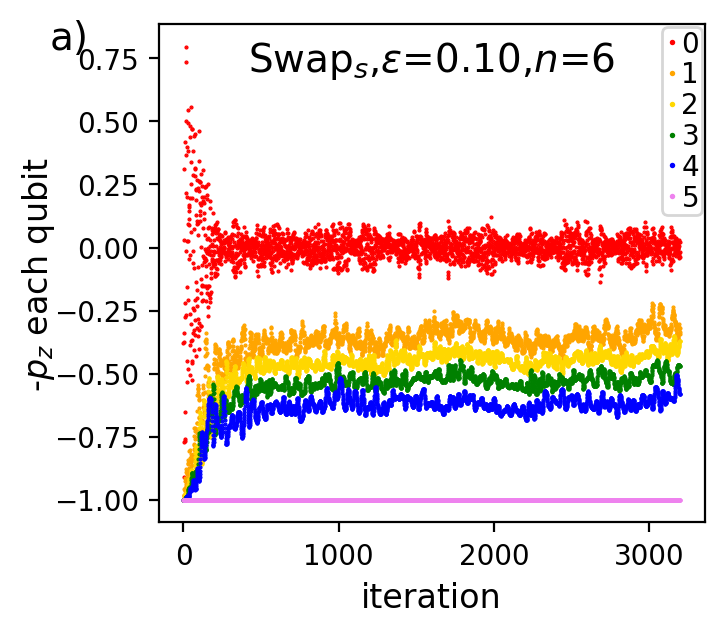

In [262]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'T1'
inter_label = 'Swap'  + '$_s$' # notice alpha beta!
tsim1 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='seq',inter_label=inter_label,alpha=0.99,beta=0.0)
mtimes = 1 
nstore = 3200
tsim1.iterate(mtimes,nstore)  # 
#sim1.simstats(1000)
sigz_fig(tsim1,mtype='z',ablabel='a)')

0.0016338435265322723 0.11051309517958274
0.3723570044774388 0.07403817418031933
0.46375715837181714 0.06236501664631158
0.5425686582248204 0.06279211075105483
0.6324313373305741 0.05421192569112285
0.999999999998584 5.022535809509226e-13
walk_03_S1b_sz.png


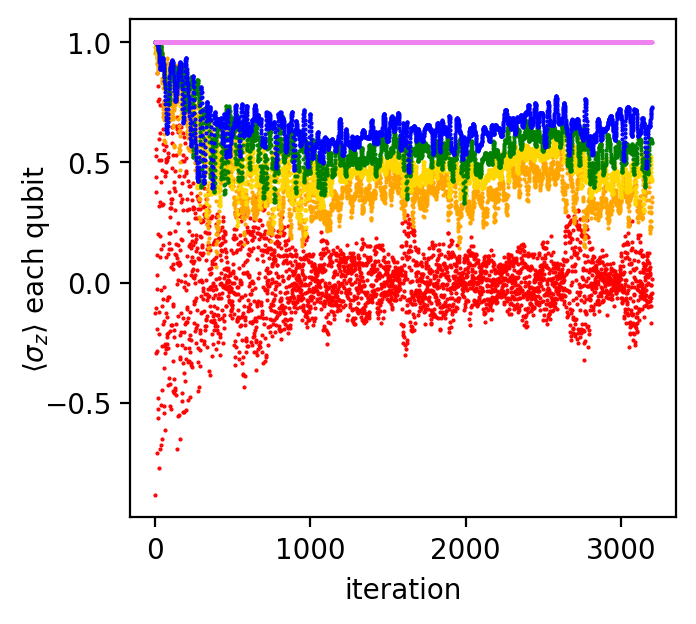

In [28]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S1br'
sim1br =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='brick')  # brick type of interaction, not much difference 
mtimes = 1 
nstore = 400*8
sim1br.iterate(mtimes,nstore)  # 
sigz_fig(sim1br,500)
sim1br.simstats(700)

0.012933564661128969 0.11302645978399284
0.37071027546911195 0.0849829175796381
0.46516806914365166 0.07235158798328747
0.5453162015008521 0.0677808606155523
0.6402443120217008 0.05832944068140111
0.9999999999982113 1.0179413340584102e-12
walk_04_H1d_sz.png


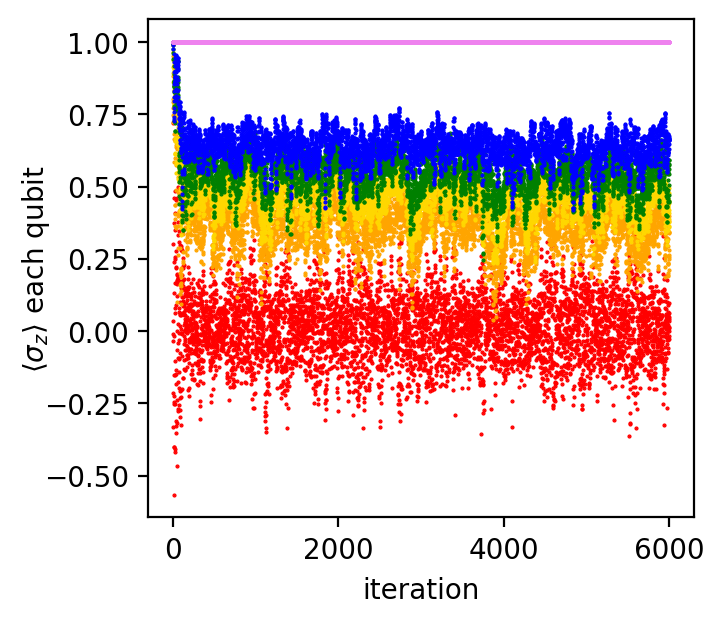

In [81]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'H1d'
mtimes = 1 
nstore = 400*15
simH1d = walkit(n_qubits,epsilon,QHeis,sim_label) # 
simH1d.iterate(mtimes,nstore)  #   
sigz_fig(simH1d,0)
simH1d.simstats(1000)

0.016319167356279418 0.10018104323301297
0.3642363075660905 0.06942997506186656
0.4340169007104958 0.0639759827858437
0.4807482000206573 0.0587151894131611
0.5298782813678015 0.05188303532817835
0.5898396608164782 0.04775854516640882
0.657513043630114 0.04431882879939804
0.9999999999971221 1.3646983021968999e-12
walk_04_H1e_sz.png


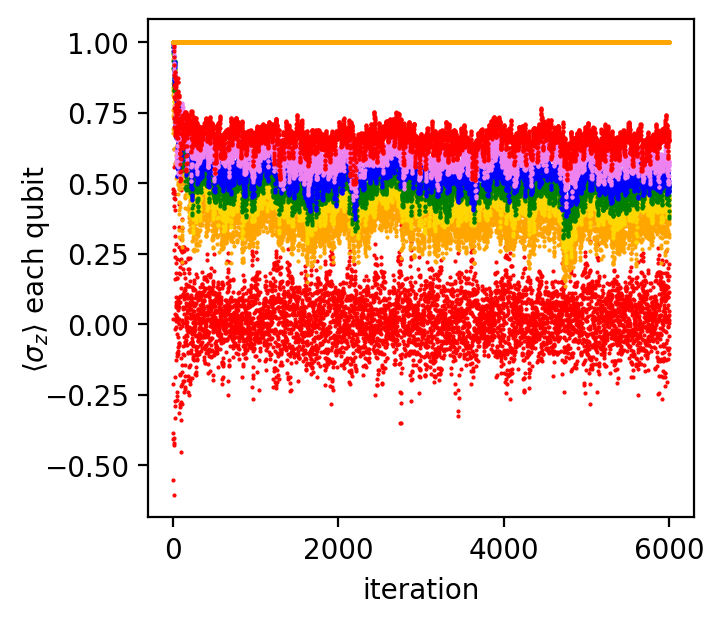

In [82]:
n_qubits = 8
epsilon = 0.1;
sim_label = 'H1e'
mtimes = 1 
nstore = 400*15
simH1e = walkit(n_qubits,epsilon,QHeis,sim_label) # 
simH1e.iterate(mtimes,nstore)  #   
sigz_fig(simH1e,0)
simH1e.simstats(1000)

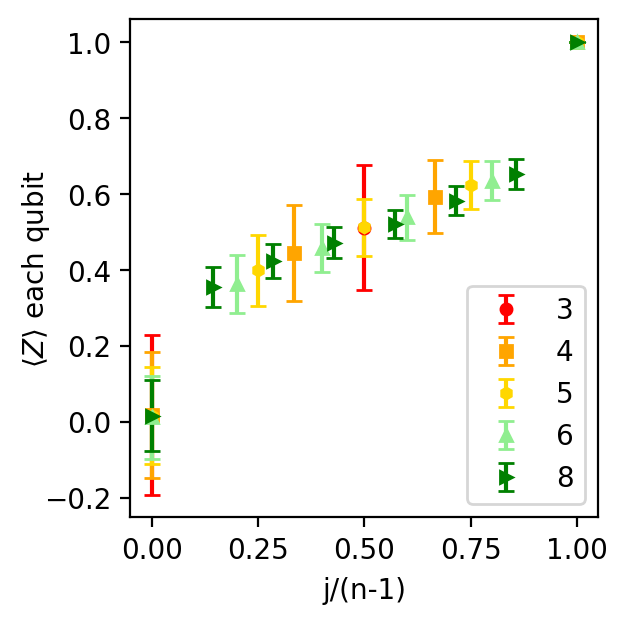

In [113]:
ofile = fileroot + '_ncomp_Heis.png'
simlist = [simH1, simH1b, simH1c, simH1d, simH1e]
nfig(simlist,ofile)


0.00951618912120489 0.10370718719825713
0.15650583825302625 0.08354108242884675
0.27297700004353315 0.06325219841487185
0.38861456340214556 0.060555607053384856
0.5469561632018048 0.05102472803039006
0.665397962368994 0.039769423442177675
0.8716745349223074 0.01750709502452356
0.9999999999991303 4.104597866525613e-14
walk_04_S8_sz.png


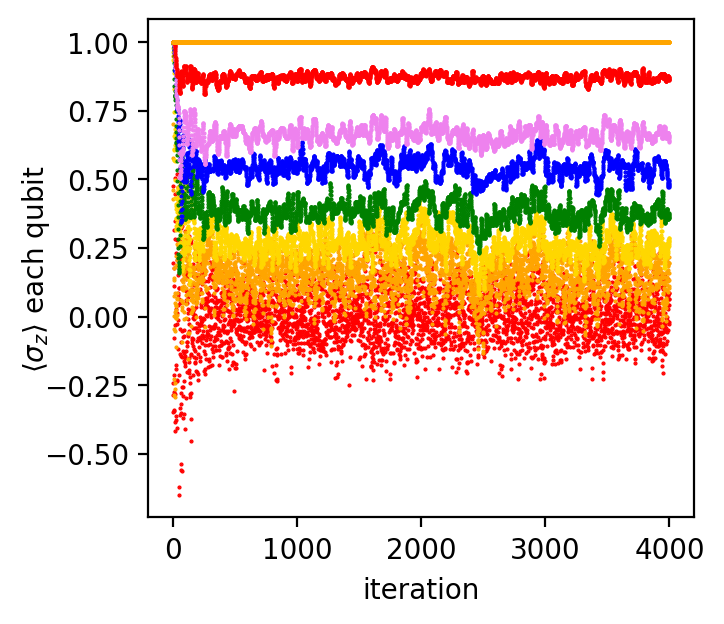

In [102]:
n_qubits = 8
epsilon_arr = np.array([0.15, 0.05, 0.05, 0.06, 0.08, 0.11, 0.15]);
sim_label = 'S8'
mtimes = 1 
nstore = 400*10
sim8 = walkit(n_qubits,epsilon_arr,QHeis,sim_label) # 

sim8.iterate(mtimes,nstore)  
sigz_fig(sim8,0)
sim8.simstats(1000)

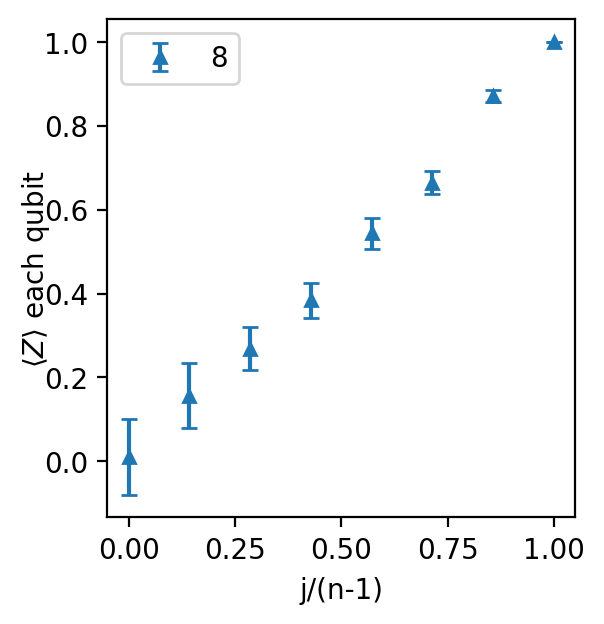

In [103]:
ofile = fileroot + '_ncomp_eps_Heis.png'
simlist = [sim8]
nfig(simlist,ofile)

0.0011007646482150662 0.15249568987272494
0.433524360177871 0.11592664507912497
0.5171635780854562 0.10561014120072626
0.5840604928617539 0.09388553699034985
0.6749932365808736 0.07141763902833695
1.00000000000115 6.96907919315695e-13
walk_03_S2_sz.png


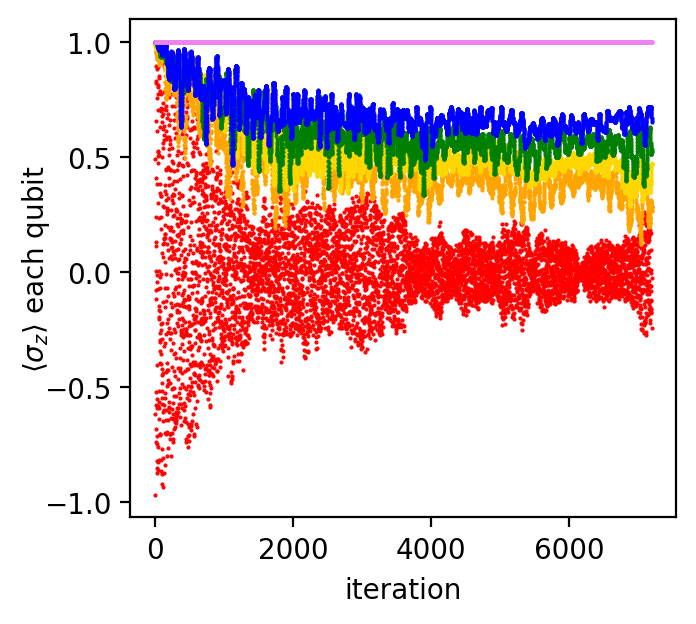

In [16]:
n_qubits = 6
epsilon = 0.05;
sim_label = 'S2'
mtimes = 1 
nstore = 400*18
sim2 =  walkit(n_qubits,epsilon,Qswap,sim_label)
sim2.iterate(mtimes,nstore)  # 
sigz_fig(sim2,500)

In [ ]:
sigz_moving_fig(sim1,200)
sigz_moving_fig(sim2,400)

0.0016376139099595977 0.11633021207207739
0.151608319930675 0.08668432550611416
0.18955710604806167 0.08078979618600006
0.2799950594623723 0.08885995197735379
0.47467810812632605 0.07750561842814388
0.9999999999992795 3.0292908502115183e-13
walk_03_S3_sz.png


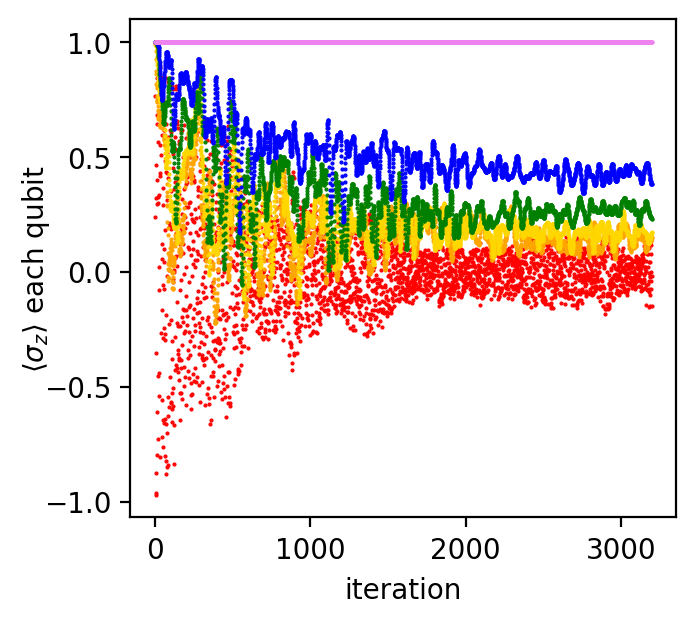

In [17]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S3'
sim3 =  walkit(n_qubits,epsilon,0.5*Qswap+0.5*QCnotC0,sim_label)
#junk1.do_channel()
mtimes = 1 
nstore = 400*8
sim3.iterate(mtimes,nstore)  # 
sigz_fig(sim3,500)

0.0009977222550743398 0.12827095867004465
0.11262280540140841 0.0649290577564203
0.1544347320748384 0.07802752213627392
0.18396002460837416 0.06515840027838805
0.2984075326630738 0.07761504118235384
0.9999999999993631 2.4584765328144787e-13
walk_03_S4_sz.png


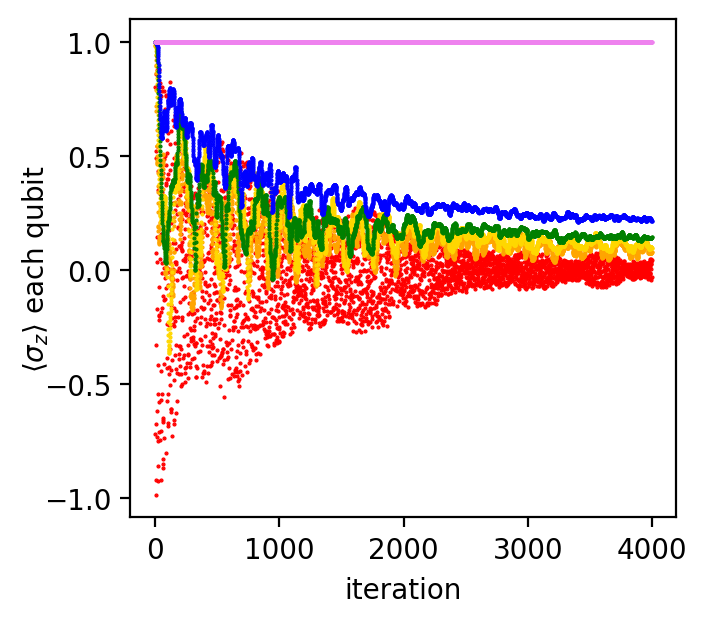

In [18]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S4'
mtimes = 1 
nstore = 400*10
sim4 =  walkit(n_qubits,epsilon,0.2*Qswap+0.8*QCnotC0,sim_label)
#junk1.do_channel()
sim4.iterate(mtimes,nstore)  # 
sigz_fig(sim4,500)

0.0015452527265299193 0.13363297532158377
0.2900483894394576 0.09934908361215403
0.25997476224457006 0.09032824446351871
0.28425009122188644 0.10016888944515229
0.4181716738296318 0.08983283520324764
1.0 1.805513236600925e-16
walk_03_S5_sz.png


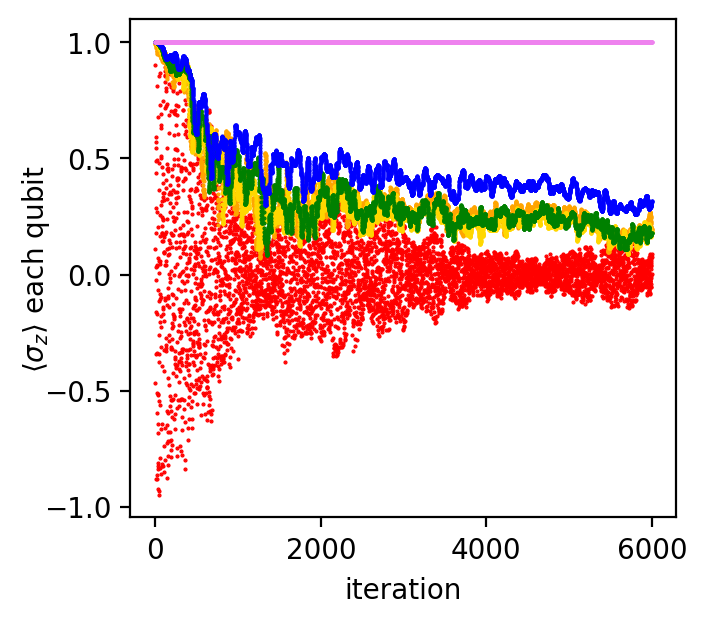

In [21]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S5'
mtimes = 1 
nstore = 400*15
sim5 =  walkit(n_qubits,epsilon,0.5*Qswap+0.5*QCnotC1,sim_label)
#junk1.do_channel()
sim5.iterate(mtimes,nstore)  # 
sigz_fig(sim5,500)

0.0041867162746669845 0.21213466220108038
0.5193514134995871 0.15326642141408978
0.5214835328811721 0.13636764376186084
0.5207136626453319 0.13687014735800213
0.5233837450128402 0.14740653968777193
1.0 1.864141070515652e-16
walk_03_S6_sz.png


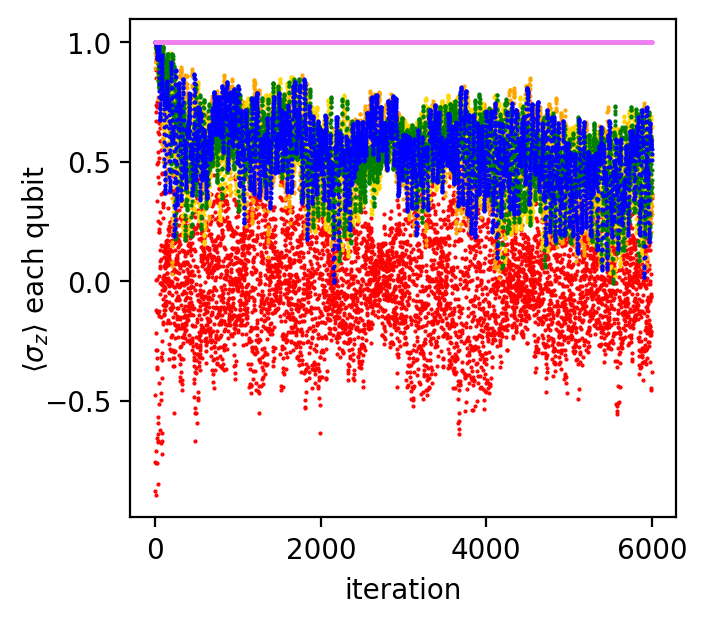

In [22]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S6'
mtimes = 1 
nstore = 400*15
sim6 =  walkit(n_qubits,epsilon,Qswap_short,sim_label)
sim6.iterate(mtimes,nstore)  # 
sigz_fig(sim6,500)

In [23]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S7'
mtimes = 1 
nstore = 400*15
sim7 = walkit(n_qubits,epsilon,QHeis,sim_label)
sim7.do_channel()
#sim7.iterate(mtimes,nstore)  # 
#sigz_fig(sim7,500)

## everything below is garbage for testing 